## Code for plotting heritability error bars.
#### E Flynn
#### 5/28/2018

In [1]:
require('ggplot2')
require('stringr')
require('tidyr')

source('/scratch/PI/mrivas/users/erflynn/sex_div_gwas/mixture_model_scripts/model_utils.R')
source('/scratch/PI/mrivas/users/erflynn/sex_div_gwas/mixture_model_scripts/heritability_utils.R')
DATA.FOLDER <- "/scratch/PI/mrivas/users/erflynn/sex_div_gwas/data/"

Loading required package: ggplot2
Loading required package: stringr
Loading required package: tidyr
Loading required package: MASS
Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand

Loading required package: mnormt
Loading required package: qqman

For example usage please run: vignette('qqman')

Citation appreciated but not required:
Turner, S.D. qqman: an R package for visualizing GWAS results using Q-Q and manhattan plots. biorXiv DOI: 10.1101/005165 (2014).

Loading required package: rstan
Loading required package: StanHeaders
rstan (Version 2.17.3, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

Attaching package: ‘rstan’

The following object is masked from ‘package:tidyr’:

    extract



In [2]:
setwd("data/dat_set/")

summary_files <- list.files(pattern=".txt$")
v2.files <- list.files(pattern="v2.txt$")
v1.files <- setdiff(summary_files, v2.files)
v1.only <- setdiff(v1.files,"ref_data.txt")
s <- lapply(v1.only, function(x) {read.table(x, header=TRUE)})
s.tab <- do.call(rbind, s)
s.tab <- s.tab[s.tab$rg > 0,]

### need to filter out last two - appears they didn't converge ("nucleated ...")

#s.tab$trait <- factor(s.tab$trait, levels=s.tab$trait[order(-s.tab$rg)])
#ggplot(s.tab, aes(x=trait, y=rg))+geom_errorbar(aes(ymin=rg.l, ymax=rg.u)) + geom_point(fill="white")
ref <- read.delim("../multi_run_gwas_input.txt", header=FALSE)
ref2 <- read.delim("../set_traits2.txt", header=FALSE)
ref2$trait.name <- gsub(" ", "_", str_trim(ref2$V3))
ref2$trait <- sapply(ref2$V2, as.character)
ref$trait.name <- gsub(" ", "_", str_trim(paste(ref$V4, ref$V5)))
ref$trait <- sapply(ref$V1, as.character)

ref.total <- rbind(ref[,c("trait", "trait.name")], ref2[,c("trait", "trait.name")])

s.tab$trait <- sapply(s.tab$trait, as.character)

s.tab2 <- merge(ref.total[,c("trait", "trait.name")], s.tab, by="trait")
s.tab2$trait.name <- factor(s.tab2$trait.name, levels=s.tab2$trait.name[order(-s.tab2$rg)])


Load the literature reference data - we want to look for comparisons

In [3]:
lit <- read.table("ref_data.txt", header=TRUE)
lit$source <- "literature"
s.tab2$source <- "estimated" 

ref.lit <- merge(lit[,c("rg", "rg.l", "rg.u", "trait.name")], s.tab2[,c("trait.name", "rg", "rg.l", "rg.u")], by="trait.name")

ref.lit2 <- rbind(lit[lit$trait.name %in% ref.lit$trait.name,c("trait.name", "rg", "rg.l", "rg.u", "source")], s.tab2[ s.tab2$trait.name %in% ref.lit$trait.name,c("trait.name", "rg", "rg.l", "rg.u", "source")])

res <- s.tab2[,c("trait.name", "rg", "rg.l", "rg.u", "source")]
ref.lit3 <- rbind(ref.lit2, res)
ref.lit3 <- ref.lit3[!duplicated(ref.lit3),]

# do some fake filtering
to.skip <- sapply(ref.lit3$trait.name, function(x){x <- strsplit(as.character(x), "_", fixed=TRUE)[[1]];  x[[length(x)]] %in% c("volume", 
	"count", "fraction", "concentration", "width", "measure", "mass", "haemoglobin", "crit", "urine", "body", "percentage")})
ref.lit4 <- ref.lit3[!to.skip,]
to.skip2 <- sapply(ref.lit4$trait.name, function(x){x <- strsplit(as.character(x), "_", fixed=TRUE)[[1]];  ifelse(length(x) > 1, x[[(length(x)-1)]] %in% c("leg", "arm", "percentage"), FALSE)})
ref.lit4 <- ref.lit4[!to.skip2,]
ref.lit4$trait.name <- gsub("_", " ", ref.lit4$trait.name)
ref.lit4$trait.name[ref.lit4$trait.name=="FEV-1"] <- "forced expiratory vol"
ref.lit4$trait.name[ref.lit4$trait.name=="PEF"] <- "peak expiratory flow"
ref.lit4$trait.name[ref.lit4$trait.name=="FVC"] <- "forced vital capacity"
ref.lit4$trait.name[ref.lit4$trait.name=="Hand grip strength (right)"] <- "grip strength (r)"

ref.lit4est <- ref.lit4[ref.lit4$source=="estimated",]

ref.lit4$trait.name <- factor(ref.lit4$trait.name, levels=ref.lit4est$trait.name[order(-ref.lit4est$rg)])


In [4]:
require('plyr')
setwd("../herit")
herit_files <- list.files(pattern=".txt$")
herit.df = ldply(herit_files, read.table) 


Loading required package: plyr


In [5]:
colnames(herit.df) <- c("value", "trait", "int", "sex")
dim(herit.df)
herit.df$sex[herit.df$sex==1] <- "h.f"
herit.df$sex[herit.df$sex==2] <- "h.m"
herit.df2 <- herit.df[complete.cases(herit.df),]

[1] 343   4

In [6]:
herit.est <- s.tab2[,c("trait", "trait.name", "h.f", "h.m")]
herit.est1 <- herit.est[!duplicated(herit.est$trait),]

In [7]:
require('reshape2')
herit.est2 <- melt(herit.est1, id.vars=c("trait", "trait.name"))
colnames(herit.est2)[3] <- "sex"
herit.est2$int <- "val"

herit.full.df <- rbind(herit.est2[,c("trait", "int", "sex", "value")], 
                       herit.df2[,c("trait", "int", "sex", "value")])
herit.full.df2 <-merge(herit.est2[,c("trait", "trait.name")], herit.full.df)
dim(herit.full.df2)
herit.full.df3 <- (herit.full.df2[!duplicated(herit.full.df2),])
dim(herit.full.df3)
head(herit.full.df3)

Loading required package: reshape2

Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths



[1] 884   5

[1] 402   5

trait,trait.name,int,sex,value
20015,Sitting_height,up,h.f,0.2830188
20015,Sitting_height,val,h.m,0.3217220
20015,Sitting_height,up,h.m,0.2908920
20015,Sitting_height,low,h.f,0.2694423
20015,Sitting_height,val,h.f,0.3104602
20015,Sitting_height,low,h.m,0.2794687


In [20]:
herit.full.df3.wide <- dcast(herit.full.df3, trait + trait.name + sex ~ int, value.var="value")
head(herit.full.df3.wide)

# ruh-roh - the val is high. I think because it was estimated previously? 
# But even so, going to skip using this for now, and stick to my new estimates.

trait,trait.name,sex,low,up,val
20015,Sitting_height,h.f,0.26944235,0.2830188,0.3104602
20015,Sitting_height,h.m,0.27946874,0.2908920,0.3217220
20022,Birth_weight,h.f,0.11783449,0.1518512,0.1531801
20022,Birth_weight,h.m,0.08733553,0.1014882,0.1085615
20150,FEV-1,h.f,0.19522586,0.2081775,0.2395176
20150,FEV-1,h.m,0.19362649,0.1975599,0.2342194


In [10]:
low.df <- dcast(herit.full.df3.wide, trait + trait.name ~ sex, value.var="low")
high.df <- dcast(herit.full.df3.wide, trait + trait.name ~ sex, value.var="up")

combined.df <- merge(low.df, high.df, by=c("trait", "trait.name"))
head(combined.df)
#apply(combined.df, 1, function(x) if (x[3] < x[4] & )

trait,trait.name,h.f.x,h.m.x,h.f.y,h.m.y
20015,Sitting_height,0.2694423,0.27946874,0.2830188,0.2908920
20022,Birth_weight,0.1178345,0.08733553,0.1518512,0.1014882
20150,FEV-1,0.1952259,0.19362649,0.2081775,0.1975599
20151,"Forced_vital_capacity_(FVC),_Best_measure",0.2029411,0.20254618,0.2179172,0.2157856
21001,BMI,0.2287786,0.22536318,0.2384327,0.2318960
30000,White_blood_cell_(leukocyte)_count,0.1981338,0.18843632,0.2144482,0.2005440


In [11]:
#Compare to literature
ref.lit.mat <- merge(lit[,c("trait.name", "h.f", "h.m")], combined.df, by="trait.name")
ref.lit.mat

## - as compared to the literature, these are a little low... vs. what was before.
## however, I think I'm just going to go with the estimates I have - this is all I can do

trait.name,h.f,h.m,trait,h.f.x,h.m.x,h.f.y,h.m.y
basal_metabolic_rate,0.30,0.36,INI23105,0.2366266,0.2653440,0.2495692,0.2722908
BMI,0.26,0.27,21001,0.2287786,0.2253632,0.2384327,0.2318960
body_fat_percentage,0.26,0.27,INI23099,0.2051935,0.2236070,0.2154693,0.2320675
BP-diastolic,0.20,0.18,4079,0.1895562,0.1422455,0.2077569,0.1552478
BP-systolic,0.20,0.17,4080,0.1875399,0.1407815,0.2040562,0.1489388
FEV-1,0.27,0.28,20150,0.1952259,0.1936265,0.2081775,0.1975599
FVC,0.26,0.26,3063,0.2153124,0.2027530,0.2291620,0.2069454
height,0.54,0.53,50,0.3637281,0.3354551,0.3752590,0.3449360
hip_circum,0.24,0.27,49,0.2026588,0.2309332,0.2172998,0.2324851
PEF,0.23,0.23,3064,0.1583237,0.1609273,0.1745391,0.1711910


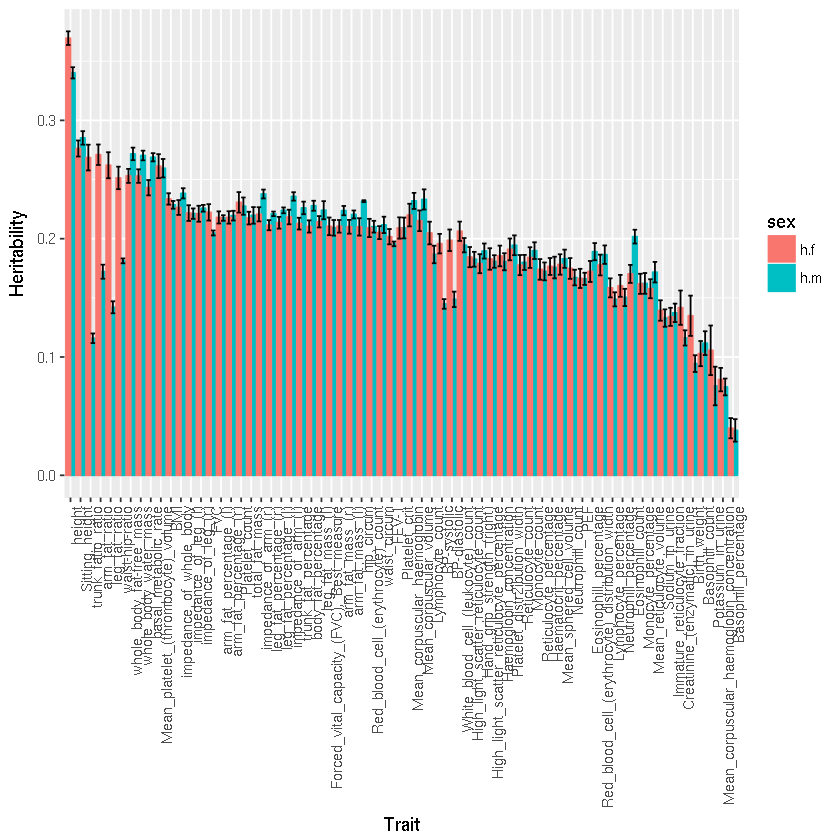

In [32]:
herit.full.df3.wide$trait.name <- factor(herit.full.df3.wide$trait.name, levels=herit.est1$trait.name[order(-herit.est1$h.f)])
herit.full.df3.wide$mid <- rowMeans(herit.full.df3.wide[,c(4,5)])
#herit.full.df3.wide$mid <- data.frame(apply(herit.full.df3.wide, 1, function(x) mean(x[5],x[4])))
ggplot(herit.full.df3.wide, aes(x=trait.name, y=mid, fill=sex, color=sex))+geom_bar(stat="identity", 
           position=position_dodge())+geom_errorbar(aes(ymin=low, ymax=up), position=position_dodge(), color="black") + theme(axis.text.x=element_text(angle=90,hjust=1)) +ylab("Heritability")+xlab("Trait")

# this looks pretty but I want it to be a bar-chart

In [33]:
list.traits <- read.delim(sprintf("%s/list_traits_run_lab.txt", DATA.FOLDER), stringsAsFactors=FALSE)
keep.traits <- data.frame(apply(list.traits, c(1,2), function(x) str_trim(x)))
keep.traits2 <- keep.traits[!is.na(keep.traits$readable.name) & keep.traits$readable.name!="NA",]

trait,trait.1,readable.name,category
whr,waist-hip-ratio,waist-hip ratio,anthropometric traits
21001,BMI,BMI,anthropometric traits
50,height,height,anthropometric traits
48,waist_circum,waist circum,anthropometric traits
49,hip_circum,hip circum,anthropometric traits
4079,BP-diastolic,BP-diastolic,lab test


trait,trait.name,sex,low,up,val,mid,readable.name,category
20015,Sitting_height,h.m,0.27946874,0.2908920,0.3217220,0.28518035,sitting height,anthropometric traits
20015,Sitting_height,h.f,0.26944235,0.2830188,0.3104602,0.27623059,sitting height,anthropometric traits
20022,Birth_weight,h.m,0.08733553,0.1014882,0.1085615,0.09441187,birth weight,anthropometric traits
20022,Birth_weight,h.f,0.11783449,0.1518512,0.1531801,0.13484284,birth weight,anthropometric traits
20150,FEV-1,h.f,0.19522586,0.2081775,0.2395176,0.20170166,forced expiratory volume,breathing
20150,FEV-1,h.m,0.19362649,0.1975599,0.2342194,0.19559318,forced expiratory volume,breathing



FALSE  TRUE 
   82    52 

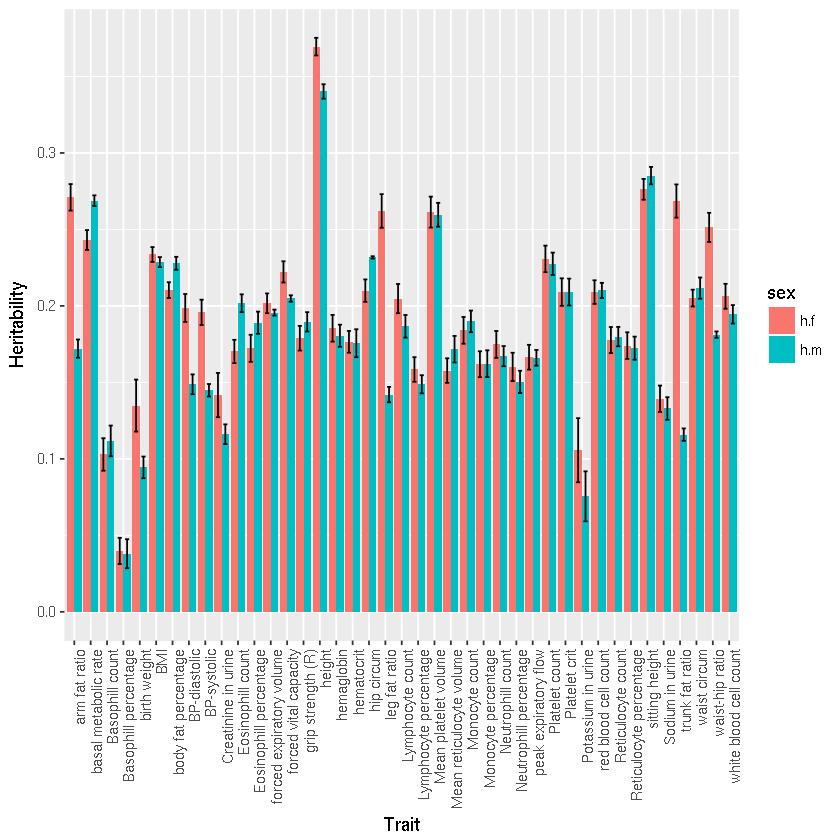

In [79]:
# rename - and group by category
head(keep.traits2)

herit.full.df4 <- merge(herit.full.df3.wide, keep.traits2[,c("trait","readable.name", "category")], by="trait", all.x=TRUE)
head(herit.full.df4)

# rename - and group by category
table(is.na(herit.full.df4$readable.name))

ggplot(herit.full.df4[!is.na(herit.full.df4$readable.name),], aes(x=readable.name, y=mid, fill=sex))+geom_bar(stat="identity",
           position=position_dodge())+geom_errorbar(aes(ymin=low, ymax=up), position=position_dodge(0.9), color="black", width=0.5) + theme(axis.text.x=element_text(angle=90,hjust=1)) +ylab("Heritability")+xlab("Trait")


In [72]:
levels(herit.full.df4$category)

[1] "anthropometric traits" "blood composition"     "breathing"            
[4] "fat distribution"      "hearing test"          "lab test"             
[7] "physical test"         "urinalysis"

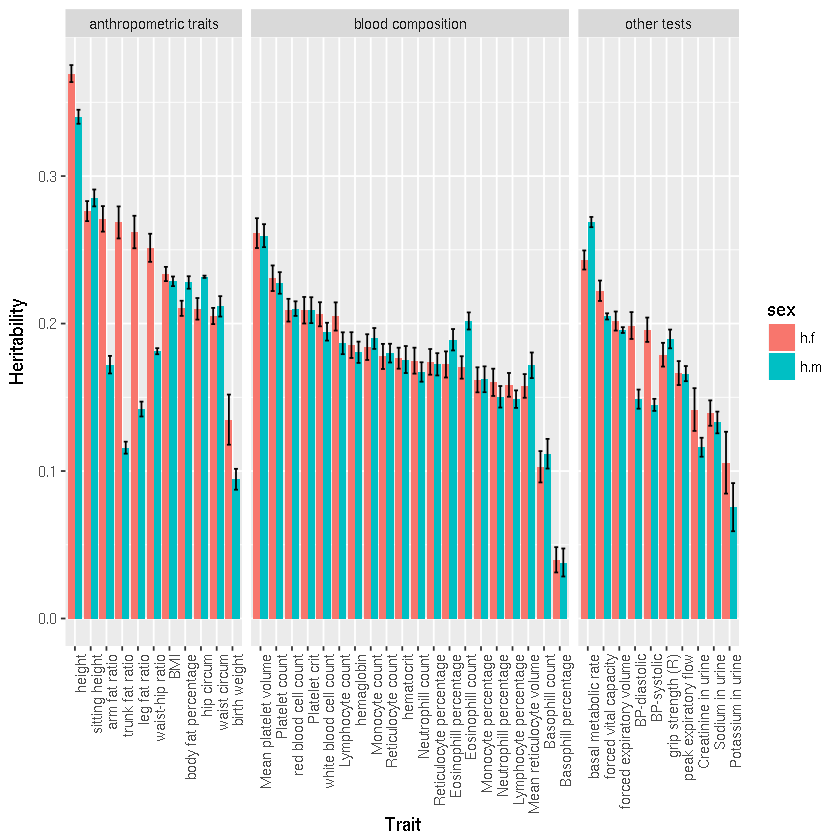

In [80]:
herit.full.df4$category <- sapply(herit.full.df4$category, as.character)
herit.full.df4$category[herit.full.df4$category=="fat distribution"] <-"anthropometric traits"
herit.full.df4$category[herit.full.df4$category=="breathing"] <-"lab test"
herit.full.df4$category[herit.full.df4$category=="urinalysis"] <-"lab test"
herit.full.df4$category[herit.full.df4$category=="physical test"] <-"lab test"
herit.full.df4$category[herit.full.df4$category=="lab test"] <- "other tests"

herit.full.df4$category <- as.factor(herit.full.df4$category)
herit.full.df4$readable.name <- factor(herit.full.df4$readable.name, levels=herit.full.df4[herit.full.df4$sex=="h.f",]$readable.name[order(-herit.full.df4[herit.full.df4$sex=="h.f",]$mid)])
herit.full.df4[!is.na(herit.full.df4$readable.name), ] %>% 
ggplot( aes(x=readable.name, y=mid, fill=sex))+geom_bar(stat="identity",
           position=position_dodge())+geom_errorbar(aes(ymin=low, ymax=up), position=position_dodge(0.9), color="black", width=0.5) + theme(axis.text.x=element_text(angle=90,hjust=1)) +ylab("Heritability")+xlab("Trait")+ facet_grid(. ~ category,  scales="free", space="free")

png 
  2

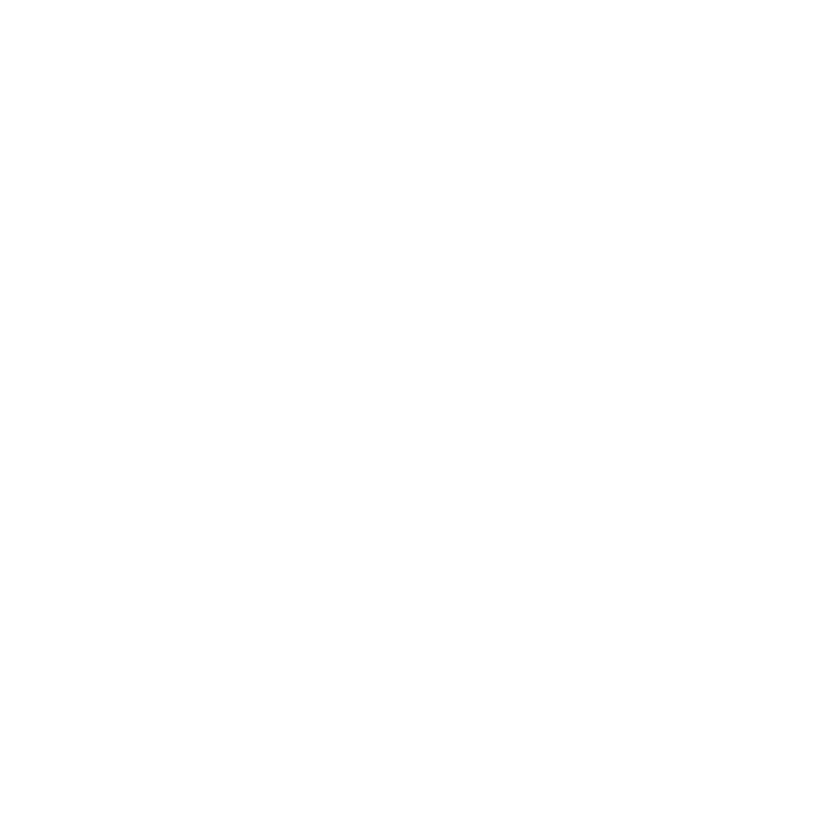

In [84]:
plot.new() 
pdf( "herit_bars.pdf", width=14, height=8)
herit.full.df4[!is.na(herit.full.df4$readable.name), ] %>% 
ggplot( aes(x=readable.name, y=mid, fill=sex))+geom_bar(stat="identity",
           position=position_dodge())+geom_errorbar(aes(ymin=low, ymax=up), position=position_dodge(0.9), color="black", width=0.5) + theme(axis.text.x=element_text(angle=90,hjust=1)) +ylab("Heritability")+xlab("Trait")+ facet_grid(. ~ category,  scales="free", space="free")
dev.off()


In [13]:

herit.vals <- lapply(keep.traits$trait, function(trait){
    fit.file=sprintf("%s/dat_set/f_%s.RData", DATA.FOLDER, trait)
    print(trait)

    if (!file.exists(fit.file) | as.charcter(trait)=="30230"){
        return(list("1"=NA, "2"=NA))

    }
    load(file=fit.file)
    load(file=sprintf("%s/dat_set/dat_%s.RData", DATA.FOLDER, trait))

    dat <- labelCategories(dat, getSigma(fit1), getPi(fit1))
    h <- overallHeritability(dat, getSigma(fit1), getPi(fit1))
    print(h) 
    return(h)
})

[1] whr
77 Levels: 20015 20019 20021 20022 20150 20151 21001 21021 30000 ... whr
$`1`
[1] 0.2497339

$`2`
[1] 0.1803766

[1] 21001
77 Levels: 20015 20019 20021 20022 20150 20151 21001 21021 30000 ... whr
$`1`
[1] 0.2334193

$`2`
[1] 0.2264415

[1] 50
77 Levels: 20015 20019 20021 20022 20150 20151 21001 21021 30000 ... whr
$`1`
[1] 0.3676052

$`2`
[1] 0.3398053

[1] 48
77 Levels: 20015 20019 20021 20022 20150 20151 21001 21021 30000 ... whr
$`1`
[1] 0.2024033

$`2`
[1] 0.2140873

[1] 49
77 Levels: 20015 20019 20021 20022 20150 20151 21001 21021 30000 ... whr
$`1`
[1] 0.2093903

$`2`
[1] 0.2276336

[1] 4079
77 Levels: 20015 20019 20021 20022 20150 20151 21001 21021 30000 ... whr
$`1`
[1] 0.1958336

$`2`
[1] 0.1460049

[1] 4080
77 Levels: 20015 20019 20021 20022 20150 20151 21001 21021 30000 ... whr
$`1`
[1] 0.1914024

$`2`
[1] 0.1457408

[1] 20150
77 Levels: 20015 20019 20021 20022 20150 20151 21001 21021 30000 ... whr
$`1`
[1] 0.2003369

$`2`
[1] 0.1946581

[1] 3063
77 Levels: 20015 200

ERROR: Error in se.p2[, 1]: incorrect number of dimensions


In [14]:
save(herit.vals, file="herit.RData")

ERROR: Error in save(herit.vals, file = "herit.RData"): object ‘herit.vals’ not found


In [38]:
# options: 
# - recalculate heritability

trait <- 'whr'
load(file=sprintf("%s/dat_set/dat_%s.RData", DATA.FOLDER, trait))
load(file=sprintf("%s/dat_set/f_%s.RData", DATA.FOLDER, trait))

dat <- labelCategories(dat, getSigma(fit1), getPi(fit1))
overallHeritability(dat, getSigma(fit1), getPi(fit1))

$`1`
[1] 0.2497339

$`2`
[1] 0.1803766

In [29]:
B_dat <- dat$dat$B
SE_dat <- dat$dat$SE
N <- dat$dat$N

posteriors <- sapply(1:N, function(i) getPosterior(B_dat[i,], SE_dat[i,], getPi(fit1), getSigma(fit1)))
dat$posteriors <- posteriors
categories <- sapply(posteriors, getCategory)

In [35]:
dat$categories <- categories

In [36]:
table(dat$categories)


     1      2 
275903   5887 

In [60]:
list.traits <- read.delim(sprintf("%s/list_traits_run_lab.txt", DATA.FOLDER), stringsAsFactors=FALSE)

In [62]:
new.traits <- merge(traits[,c("trait", "readable.name", "category")], herit.full.df3.wide, by="trait")

In [68]:
new.traits2 <- data.frame(apply(new.traits, c(1,2), function(x) str_trim(x)))

In [71]:
new.traits3 <- new.traits2[new.traits2$readable.name!="NA",]

In [72]:
new.traits3 ### GAH I LABELED THE WRONG THING

,trait,readable.name,category,trait.name,sex,low,up,val
1,INI23099,body fat percentage,fat distribution,body_fat_percentage,h.f,0.2051935,0.2154693,0.2532213
2,INI23099,body fat percentage,fat distribution,body_fat_percentage,h.m,0.2236070,0.2320675,0.2718347
11,INI23105,basal metabolic rate,lab test,basal_metabolic_rate,h.m,0.2653440,0.2722908,0.3080162
12,INI23105,basal metabolic rate,lab test,basal_metabolic_rate,h.f,0.2366266,0.2495692,0.2813215
39,trunk_fp,trunk fat ratio,fat distribution,trunk_fatio_ratio,h.f,0.2577097,0.2794347,0.3077835
40,trunk_fp,trunk fat ratio,fat distribution,trunk_fatio_ratio,h.m,0.1117804,0.1199040,0.1358248
